## Dataset Prep

In [2]:
 #!pip install torch torchvision matplotlib numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

100%|██████████| 170M/170M [00:05<00:00, 29.8MB/s]


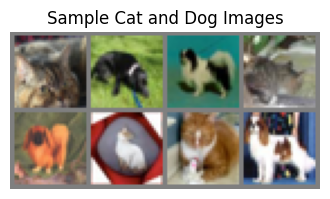

Dataset preparation complete.
Number of training samples (cats and dogs): 10000
Number of test samples (cats and dogs): 2000


In [3]:
# Step 1: Dataset Preparation
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np

# Define transformation:
# - Convert images to tensors
# - Normalize the images to have pixel values in the range [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Download the CIFAR-10 dataset for training and testing
trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# CIFAR-10 classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Define the class indices for 'cat' and 'dog'
cat_dog_class_indices = [3, 5]

# Filter the training set to only include images of cats and dogs
cat_dog_train_indices = [i for i, label in enumerate(trainset.targets) if label in cat_dog_class_indices]
cat_dog_test_indices = [i for i, label in enumerate(testset.targets) if label in cat_dog_class_indices]

# Create subset datasets for training and testing with only cat and dog images
cat_dog_trainset = Subset(trainset, cat_dog_train_indices)
cat_dog_testset = Subset(testset, cat_dog_test_indices)

# Helper function to display images
def imshow(img, title):
    """
    Un-normalize and display an image.
    Args:
        img (Tensor): Image tensor.
        title (str): Title for the plot.
    """
    img = img / 2 + 0.5  # Un-normalize the image (reverse normalization)
    npimg = img.numpy()
    plt.figure(figsize=(4, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Create a DataLoader to easily fetch a batch of images for visualization
data_loader = DataLoader(cat_dog_trainset, batch_size=8, shuffle=True)

# Get a batch of images and their labels
data_iter = iter(data_loader)
images, labels = next(data_iter)

# Convert numeric labels to their class names (i.e., 'cat' or 'dog')
label_names = [classes[label] for label in labels]

# Display the images in a grid with their corresponding labels as title
grid_img = torchvision.utils.make_grid(images, nrow=4)
imshow(grid_img, title="Sample Cat and Dog Images")

if __name__ == '__main__':
    print("Dataset preparation complete.")
    print("Number of training samples (cats and dogs):", len(cat_dog_trainset))
    print("Number of test samples (cats and dogs):", len(cat_dog_testset))


## GAN Model Design

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# -------------------------------
# Mini-Batch Discrimination Layer
# -------------------------------
class MiniBatchDiscrimination(nn.Module):
    """
    This layer implements mini-batch discrimination as described in:
    "Improved Techniques for Training GANs" (Salimans et al., 2016).
    It encourages the network to generate diverse samples by comparing each sample
    in the mini-batch to all others.
    """
    def __init__(self, in_features, out_features, kernel_dims):
        super(MiniBatchDiscrimination, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.kernel_dims = kernel_dims
        # Learnable tensor T transforms the input features.
        self.T = nn.Parameter(torch.Tensor(in_features, out_features * kernel_dims))
        nn.init.normal_(self.T, 0, 1)

    def forward(self, x):
        # x: (batch_size, in_features)
        M = x.mm(self.T)  # shape: (batch_size, out_features * kernel_dims)
        M = M.view(-1, self.out_features, self.kernel_dims)  # shape: (batch_size, out_features, kernel_dims)
        batch_size = x.size(0)
        out_list = []
        # For each sample in the mini-batch, compute the distance to every other sample.
        for i in range(batch_size):
            # Compute L1 distance between sample i and all other samples
            diff = torch.abs(M[i].unsqueeze(0) - M)  # shape: (batch_size, out_features, kernel_dims)
            diff = torch.sum(diff, dim=2)  # shape: (batch_size, out_features)
            # Apply a negative exponential to obtain similarity measure
            exp_diff = torch.exp(-diff)
            # Sum over the mini-batch (exclude the self-distance)
            o_i = torch.sum(exp_diff, dim=0) - 1  # shape: (out_features,)
            out_list.append(o_i)
        out_tensor = torch.stack(out_list)  # shape: (batch_size, out_features)
        # Concatenate the original features with the mini-batch discrimination features
        return torch.cat([x, out_tensor], dim=1)

# -------------------------------
# DCGAN-Style Generator
# -------------------------------
class Generator(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=3):
        """
        Args:
            nz: Dimensionality of the latent vector.
            ngf: Base number of generator feature maps.
            nc: Number of channels in the output image.
        """
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input is the latent vector Z of shape (nz, 1, 1)
            nn.ConvTranspose2d(nz, ngf * 8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # State size: (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # State size: (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # State size: (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # State size: (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Tanh()  # Output images in range [-1, 1]
        )

    def forward(self, input):
        return self.main(input)

# -------------------------------
# Custom Discriminator (Siamese-Inspired)
# -------------------------------
class Discriminator(nn.Module):
    def __init__(self, nc=3):
        """
        The discriminator processes a pair of images (real and fake) and outputs
        a similarity score. It uses a shared CNN to extract features from each image,
        computes the absolute difference, applies mini-batch discrimination to promote
        output diversity, and finally outputs a similarity score.
        """
        super(Discriminator, self).__init__()
        # Shared feature extractor (Siamese branch)
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(nc, 64, kernel_size=4, stride=2, padding=1),  # Output: 16x16
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),   # Output: 8x8
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),   # Output: 4x4
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.flatten = nn.Flatten()
        # Expected feature dimension after convolutions: 256 * 4 * 4 = 4096
        feature_dim = 256 * 4 * 4

        # Mini-Batch Discrimination layer to encourage sample diversity
        self.mbd = MiniBatchDiscrimination(feature_dim, out_features=100, kernel_dims=5)

        # Fully-connected layer that outputs a similarity score
        # Input dimension is feature_dim + 100 (due to concatenation from MBD)
        self.fc = nn.Linear(feature_dim + 100, 1)

    def forward(self, real_img, fake_img):
        """
        Args:
            real_img: Tensor of shape [B, 3, 32, 32] (real images)
            fake_img: Tensor of shape [B, 3, 32, 32] (generated/fake images)
        Returns:
            A tensor of shape [B, 1] with similarity scores.
        """
        # Extract features for both images using the shared CNN
        real_features = self.flatten(self.feature_extractor(real_img))
        fake_features = self.flatten(self.feature_extractor(fake_img))

        # Compute absolute difference between the feature vectors
        diff_features = torch.abs(real_features - fake_features)

        # Apply mini-batch discrimination on the difference features
        mbd_features = self.mbd(diff_features)

        # Obtain the final similarity score
        score = self.fc(mbd_features)
        return score

# -------------------------------
# Example Instantiation and Forward Pass
# -------------------------------
if __name__ == '__main__':
    # Set device (use GPU if available)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Instantiate the Generator and Discriminator
    netG = Generator().to(device)
    netD = Discriminator().to(device)

    print("Generator architecture:")
    print(netG)
    print("\nDiscriminator architecture:")
    print(netD)

    # Create random noise and generate a batch of fake images
    batch_size = 8
    noise = torch.randn(batch_size, 100, 1, 1, device=device)
    fake_images = netG(noise)

    # For demonstration, use fake images as a placeholder for real images
    real_images = netG(noise)

    # Pass the real and fake image pair through the discriminator to get similarity scores
    similarity_scores = netD(real_images, fake_images)
    print("\nSimilarity scores shape:", similarity_scores.shape)
    print("Similarity scores:", similarity_scores)


Generator architecture:
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

## VAE Model

Revised VAE Model Architecture:
VAE_Skip(
  (enc_conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc_mu): Linear(in_features=4096, out_features=128, bias=True)
  (fc_logvar): Linear(in_features=4096, out_features=128, bias=True)
  (fc_decode): Linear(in_features=128, out_features=4096, bias=True)
  (dec_conv1): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec_conv2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec_conv3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec_conv4): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)
[Epoch 1/30] Batch [0/79] Loss: 1331.0945 | Recon: 1331.0945 

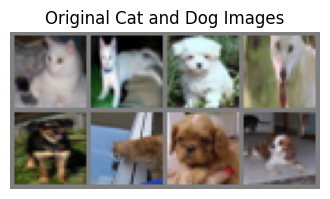

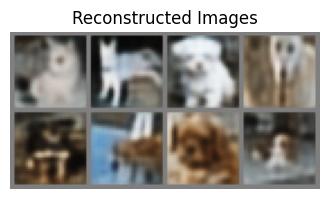

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# Revised VAE with Reduced Skip Connections (U-Net style)
# -------------------------------
class VAE_Skip(nn.Module):
    def __init__(self, latent_dim=128, beta=4.0, skip_scale=0.02):
        """
        VAE with skip connections and L1 loss for sharper reconstructions,
        but with skip connections scaled down to force reliance on the latent code.

        Args:
            latent_dim (int): Dimensionality of the latent space.
            beta (float): Weight for the KL divergence term.
            skip_scale (float): Scaling factor for skip connections (0 means no skip).
        """
        super(VAE_Skip, self).__init__()
        self.latent_dim = latent_dim
        self.beta = beta
        self.skip_scale = skip_scale

        # Encoder
        # Input: [B, 3, 32, 32]
        self.enc_conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)    # -> [B, 64, 16, 16]
        self.enc_conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)   # -> [B, 128, 8, 8]
        self.enc_conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)  # -> [B, 256, 4, 4]
        self.enc_conv4 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)  # -> [B, 256, 4, 4]

        # Flattened feature size = 256 * 4 * 4 = 4096.
        self.fc_mu = nn.Linear(4096, latent_dim)
        self.fc_logvar = nn.Linear(4096, latent_dim)

        # Decoder
        self.fc_decode = nn.Linear(latent_dim, 4096)
        # Transposed convolutions (upsampling)
        self.dec_conv1 = nn.ConvTranspose2d(256, 256, kernel_size=3, stride=1, padding=1)  # [B, 256, 4, 4]
        self.dec_conv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)   # -> [B, 128, 8, 8]
        self.dec_conv3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)    # -> [B, 64, 16, 16]
        self.dec_conv4 = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1)      # -> [B, 3, 32, 32]

    def encode(self, x):
        # Compute encoder features and store skip connections.
        skip1 = F.relu(self.enc_conv1(x))       # [B, 64, 16, 16]
        skip2 = F.relu(self.enc_conv2(skip1))     # [B, 128, 8, 8]
        skip3 = F.relu(self.enc_conv3(skip2))     # [B, 256, 4, 4]
        x4 = F.relu(self.enc_conv4(skip3))        # [B, 256, 4, 4]
        x_flat = x4.view(x4.size(0), -1)          # Flatten to [B, 4096]
        mu = self.fc_mu(x_flat)
        logvar = self.fc_logvar(x_flat)
        return skip1, skip2, skip3, mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, skip1, skip2, skip3):
        h = self.fc_decode(z)
        h = h.view(z.size(0), 256, 4, 4)         # [B, 256, 4, 4]
        h = F.relu(self.dec_conv1(h))
        h = h + self.skip_scale * skip3          # Scaled skip connection from conv3
        h = F.relu(self.dec_conv2(h))
        h = h + self.skip_scale * skip2          # Scaled skip connection from conv2
        h = F.relu(self.dec_conv3(h))
        h = h + self.skip_scale * skip1          # Scaled skip connection from conv1
        recon = torch.tanh(self.dec_conv4(h))    # Output in [-1,1]
        return recon

    def forward(self, x):
        skip1, skip2, skip3, mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z, skip1, skip2, skip3)
        return recon, mu, logvar

    def generate(self, z):
        """
        Generate images from a latent vector without using skip connections.
        This is used for sampling new images.
        """
        h = self.fc_decode(z)
        h = h.view(z.size(0), 256, 4, 4)
        h = F.relu(self.dec_conv1(h))
        h = F.relu(self.dec_conv2(h))
        h = F.relu(self.dec_conv3(h))
        recon = torch.tanh(self.dec_conv4(h))
        return recon

# -------------------------------
# Loss Function (using L1 Loss for reconstruction)
# -------------------------------
def loss_function(recon_x, x, mu, logvar, beta=4.0):
    # L1 loss tends to produce sharper outputs than MSE
    recon_loss = F.l1_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_loss, recon_loss, kl_loss

# -------------------------------
# Optional: KL Annealing (if desired)
# -------------------------------
def kl_annealing_factor(current_epoch, total_epochs, max_beta=4.0):
    # Linearly increase beta from 0 to max_beta over total_epochs
    return min(max_beta, max_beta * (current_epoch / total_epochs))

# -------------------------------
# Training Function for the Revised VAE
# -------------------------------
def train_vae(vae, dataloader, num_epochs=50, learning_rate=1e-4, device=torch.device("cpu")):
    optimizer = optim.Adam(vae.parameters(), lr=learning_rate)
    vae.train()

    for epoch in range(num_epochs):
        total_loss = 0.0
        total_recon_loss = 0.0
        total_kl_loss = 0.0

        current_beta = kl_annealing_factor(epoch, num_epochs, max_beta=vae.beta)

        for batch_idx, (data, _) in enumerate(dataloader):
            data = data.to(device)
            optimizer.zero_grad()

            recon, mu, logvar = vae(data)
            loss, recon_loss, kl_loss = loss_function(recon, data, mu, logvar, beta=current_beta)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_kl_loss += kl_loss.item()

            if batch_idx % 100 == 0:
                print(f"[Epoch {epoch+1}/{num_epochs}] Batch [{batch_idx}/{len(dataloader)}] "
                      f"Loss: {loss.item()/len(data):.4f} | Recon: {recon_loss.item()/len(data):.4f} "
                      f"| KL: {kl_loss.item()/len(data):.4f} | Beta: {current_beta:.2f}")

        avg_loss = total_loss / len(dataloader.dataset)
        avg_recon = total_recon_loss / len(dataloader.dataset)
        avg_kl = total_kl_loss / len(dataloader.dataset)
        print(f"====> Epoch: {epoch+1} Avg Loss: {avg_loss:.4f} "
              f"(Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}, Beta: {current_beta:.2f})")

# -------------------------------
# Visualization Helper
# -------------------------------
def imshow(img, title):
    """
    Un-normalize and display an image.
    Assumes images are normalized to [-1,1] and converts them back to [0,1].
    """
    img = img * 0.5 + 0.5  # un-normalize
    npimg = img.cpu().numpy()
    plt.figure(figsize=(4, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

# -------------------------------
# Example Usage: Training and Evaluating the Revised VAE
# -------------------------------
if __name__ == '__main__':
    from torch.utils.data import DataLoader
    import torchvision

    # Assume 'cat_dog_trainset' is defined from the dataset preparation step.
    batch_size = 128
    train_loader = DataLoader(cat_dog_trainset, batch_size=batch_size, shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Instantiate the revised VAE with skip connections.
    vae = VAE_Skip(latent_dim=128, beta=4.0, skip_scale=0.02).to(device)
    print("Revised VAE Model Architecture:")
    print(vae)

    # Train the VAE for 30 epochs
    num_epochs = 30
    train_vae(vae, train_loader, num_epochs=num_epochs, learning_rate=1e-4, device=device)

    # Optional: Visualize reconstructions on a batch from the training set.
    vae.eval()
    with torch.no_grad():
        data, _ = next(iter(train_loader))
        data = data.to(device)
        recon_data, _, _ = vae(data)

        # Display original images and reconstructed images with consistent normalization.
        grid_original = torchvision.utils.make_grid(data[:8], nrow=4, normalize=False)
        imshow(grid_original, title="Original Cat and Dog Images")
        grid_recon = torchvision.utils.make_grid(recon_data[:8], nrow=4, normalize=False)
        imshow(grid_recon, title="Reconstructed Images")


In [46]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

class Generator(nn.Module):
    def __init__(self, nz=128, ngf=128, nc=3):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input: (nz) x 1 x 1 -> (ngf*8) x 4 x 4
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # (ngf*8) x 4 x 4 -> (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # (ngf*4) x 8 x 8 -> (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # (ngf*2) x 16 x 16 -> (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # (ngf) x 32 x 32 -> (nc) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 3, 1, 1, bias=False),
            nn.Tanh()  # Outputs in [-1, 1]
        )
    def forward(self, input):
        return self.main(input)

# -------------------------------
# Improved DCGAN Discriminator with Spectral Normalization
# -------------------------------
class Discriminator(nn.Module):
    def __init__(self, nc=3, ndf=128):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False)),
            nn.Sigmoid()
        )
    def forward(self, input):
        output = self.main(input)
        return output.view(-1)

# -------------------------------
# GAN Training Loop with Fixed Noise Evaluation and Label Smoothing
# -------------------------------
def train_gan(netG, netD, dataloader, num_epochs, device, fixed_noise):
    criterion = nn.BCELoss()
    optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

    gan_checkpoint_dir = "./checkpoints/gan"
    os.makedirs(gan_checkpoint_dir, exist_ok=True)
    sample_dir = "./samples"
    os.makedirs(sample_dir, exist_ok=True)

    for epoch in range(num_epochs):
        for i, (real_images, _) in enumerate(dataloader):
            real_images = real_images.to(device)
            batch_size = real_images.size(0)

            # Label smoothing: real labels set to 0.95
            real_label = torch.full((batch_size,), 0.95, device=device)
            fake_label = torch.full((batch_size,), 0.0, device=device)

            # Train Discriminator
            netD.zero_grad()
            output_real = netD(real_images)
            lossD_real = criterion(output_real, real_label)
            lossD_real.backward()

            noise = torch.randn(batch_size, 128, 1, 1, device=device)
            fake_images = netG(noise)
            output_fake = netD(fake_images.detach())
            lossD_fake = criterion(output_fake, fake_label)
            lossD_fake.backward()
            lossD = lossD_real + lossD_fake
            optimizerD.step()

            # Train Generator
            netG.zero_grad()
            output_fake_forG = netD(fake_images)
            lossG = criterion(output_fake_forG, real_label)
            lossG.backward()
            optimizerG.step()

            if i % 100 == 0:
                print(f"[GAN] Epoch [{epoch+1}/{num_epochs}] Batch [{i}/{len(dataloader)}] "
                      f"D Loss: {lossD.item():.4f} | G Loss: {lossG.item():.4f} | "
                      f"Real D: {output_real.mean().item():.4f}, Fake D: {output_fake.mean().item():.4f}")

        # Save checkpoints each epoch
        torch.save(netG.state_dict(), os.path.join(gan_checkpoint_dir, f"netG_epoch_{epoch+1}.pth"))
        torch.save(netD.state_dict(), os.path.join(gan_checkpoint_dir, f"netD_epoch_{epoch+1}.pth"))
        print(f"Saved GAN checkpoints for epoch {epoch+1}")

        # Generate and save sample images with fixed noise
        with torch.no_grad():
            sample_images = netG(fixed_noise).detach().cpu()
        vutils.save_image(sample_images, os.path.join(sample_dir, f"epoch_{epoch+1}_samples.png"), normalize=True)
# -------------------------------
# Main Routine for GAN Training
# -------------------------------
if __name__ == '__main__':
    # Define data transforms with augmentation
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Load CIFAR-10 and filter for cats (label 3) and dogs (label 5)
    full_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    indices = [i for i, label in enumerate(full_dataset.targets) if label in [3, 5]]
    from torch.utils.data import Subset
    cat_dog_trainset = Subset(full_dataset, indices)

    batch_size = 64
    num_epochs = 50  # Increased number of epochs for better training
    train_loader = DataLoader(cat_dog_trainset, batch_size=batch_size, shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Instantiate models with increased capacity
    netG = netG.to(device)
    netD = netD.to(device)

    # Create fixed noise for evaluation (e.g., 64 samples)
    fixed_noise = torch.randn(64, 128, 1, 1, device=device)

    print("Starting GAN training with improved settings...")
    train_gan(netG, netD, train_loader, num_epochs=num_epochs, device=device, fixed_noise=fixed_noise)
    print("GAN training complete. Checkpoints saved in './checkpoints/gan' and sample images in './samples'.")


Starting GAN training with improved settings...
[GAN] Epoch [1/50] Batch [0/157] D Loss: 1.2873 | G Loss: 1.6200 | Real D: 0.5313, Fake D: 0.4335
[GAN] Epoch [1/50] Batch [100/157] D Loss: 1.0535 | G Loss: 1.3683 | Real D: 0.5914, Fake D: 0.3734
Saved GAN checkpoints for epoch 1
[GAN] Epoch [2/50] Batch [0/157] D Loss: 1.0162 | G Loss: 1.8388 | Real D: 0.6981, Fake D: 0.4272
[GAN] Epoch [2/50] Batch [100/157] D Loss: 1.2227 | G Loss: 1.0494 | Real D: 0.3916, Fake D: 0.2120
Saved GAN checkpoints for epoch 2
[GAN] Epoch [3/50] Batch [0/157] D Loss: 1.2926 | G Loss: 1.6071 | Real D: 0.7503, Fake D: 0.5832
[GAN] Epoch [3/50] Batch [100/157] D Loss: 0.7926 | G Loss: 1.6653 | Real D: 0.6373, Fake D: 0.2398
Saved GAN checkpoints for epoch 3
[GAN] Epoch [4/50] Batch [0/157] D Loss: 1.5100 | G Loss: 1.8919 | Real D: 0.7114, Fake D: 0.6532
[GAN] Epoch [4/50] Batch [100/157] D Loss: 1.0345 | G Loss: 1.3527 | Real D: 0.5074, Fake D: 0.2630
Saved GAN checkpoints for epoch 4
[GAN] Epoch [5/50] Batch

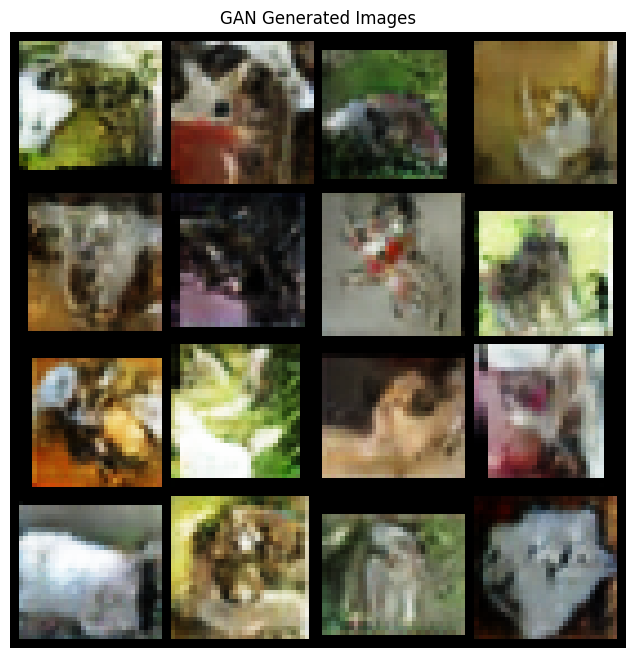

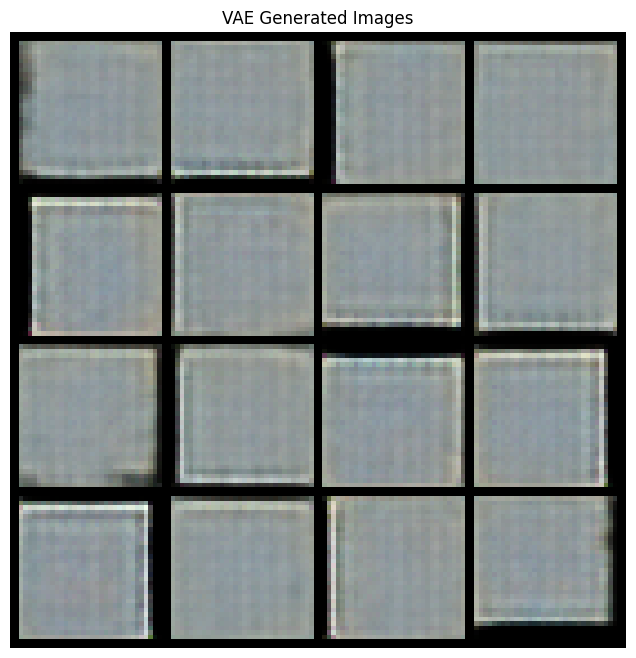

In [50]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

# -------------------------------
# Evaluation & Comparison Functions
# -------------------------------

def generate_images_gan(netG, device, n_samples=16):
    """
    Generate a batch of images using the GAN generator.

    Args:
        netG: The trained GAN generator model.
        device: The device (CPU/GPU) on which the model is located.
        n_samples: Number of images to generate.

    Returns:
        A tensor of generated images.
    """
    netG.eval()
    # Change 100 to 128 to match the generator's expected noise dimension.
    noise = torch.randn(n_samples, 128, 1, 1, device=device)
    with torch.no_grad():
        fake_images = netG(noise).detach().cpu()
    return fake_images

def generate_images_vae(vae, device, n_samples=16):
    """
    Generate a batch of images using the VAE's generate() method.
    """
    vae.eval()
    latent_dim = vae.latent_dim
    z = torch.randn(n_samples, latent_dim, device=device)
    with torch.no_grad():
        generated_images = vae.generate(z).detach().cpu()
    return generated_images


def show_images(images, title="Generated Images", nrow=4):
    """
    Display a grid of images.

    Args:
        images: A tensor of images.
        title: Title for the plot.
        nrow: Number of images per row.
    """
    grid = vutils.make_grid(images, nrow=nrow, normalize=True)
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.title(title)
    plt.axis("off")
    plt.show()

# Optionally, if you stored training metrics, you could plot them like this:
def plot_training_metrics(gan_loss_history=None, vae_loss_history=None):
    """
    Plot training losses for GAN and VAE if available.

    Args:
        gan_loss_history: Dictionary with keys 'G_loss' and 'D_loss' (lists over epochs).
        vae_loss_history: Dictionary with keys 'total_loss', 'recon_loss', 'kl_loss' (lists over epochs).
    """
    if gan_loss_history:
        plt.figure(figsize=(10, 5))
        plt.plot(gan_loss_history['G_loss'], label="Generator Loss")
        plt.plot(gan_loss_history['D_loss'], label="Discriminator Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("GAN Training Losses")
        plt.legend()
        plt.show()

    if vae_loss_history:
        plt.figure(figsize=(10, 5))
        plt.plot(vae_loss_history['total_loss'], label="Total Loss")
        plt.plot(vae_loss_history['recon_loss'], label="Reconstruction Loss")
        plt.plot(vae_loss_history['kl_loss'], label="KL Divergence Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("VAE Training Losses")
        plt.legend()
        plt.show()

# -------------------------------
# Visual Evaluation
# -------------------------------

# Assume `device` is already set and the models have been trained.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate images from the GAN
gan_images = generate_images_gan(netG, device, n_samples=16)
show_images(gan_images, title="GAN Generated Images")

# Generate images from the VAE using the new generate() method
vae_images = generate_images_vae(vae, device, n_samples=16)
show_images(vae_images, title="VAE Generated Images")

# Optionally, if you have stored training metrics, plot them:
# plot_training_metrics(gan_loss_history, vae_loss_history)

# -------------------------------
# Optional: Quantitative Metrics (Placeholder)
# -------------------------------
def compute_fid_score(generated_images, real_images):
    """
    Compute the FID score between generated images and real images.
    This is a placeholder function; please use an existing implementation for a full computation.

    Args:
        generated_images: Tensor of generated images.
        real_images: Tensor of real images from the dataset.

    Returns:
        A float representing the FID score.
    """
    fid_score = 0.0  # Replace with actual FID computation.
    return fid_score

# Example usage (if you have a batch of real images available):
# real_images, _ = next(iter(train_loader))
# fid = compute_fid_score(gan_images, real_images)
# print("FID Score for GAN:", fid)


In [14]:
!pip install -U "huggingface_hub[cli]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 2.1 MB/s eta 0:00:00


In [1]:



!huggingface-cli login



'huggingface-cli' is not recognized as an internal or external command,
operable program or batch file.


In [27]:
!git config --global credential.helper store

In [2]:
!huggingface-cli login


'huggingface-cli' is not recognized as an internal or external command,
operable program or batch file.


In [30]:
!git config --global user.email "ahmad.liberty9999@gmail.com"


In [31]:
!git config --global user.name "ahmad"


In [3]:

# -------------------------------
# Hugging Face Integration
# -------------------------------
# To push your final models to the Hugging Face Hub, first ensure you have the huggingface_hub library:
#   pip install huggingface_hub
#
# Then, authenticate using your Hugging Face token:
#   huggingface-cli login
#
# The code below demonstrates how to save your model checkpoints to disk and push them to your HF repo.

from huggingface_hub import Repository, create_repo
import shutil

# Define repository names (replace with your actual Hugging Face username and desired repo names)
gan_repo_name = "AhmadHassan71/image-generation-using-GANs"
vae_repo_name = "AhmadHassan71/vae-cat-dog-image-generation"

# Save final model checkpoints to disk
torch.save(netG.state_dict(), "netG_final.pth")
torch.save(netD.state_dict(), "netD_final.pth")
torch.save(vae.state_dict(), "vae_final.pth")

# Create repositories on Hugging Face Hub (if they do not exist already)
create_repo(gan_repo_name, exist_ok=True)
create_repo(vae_repo_name, exist_ok=True)

# Clone the repositories locally into separate folders
gan_local_dir = "gan_model"
vae_local_dir = "vae_model"

# Remove directories if they already exist (for a clean push)
if os.path.exists(gan_local_dir):
    shutil.rmtree(gan_local_dir)
if os.path.exists(vae_local_dir):
    shutil.rmtree(vae_local_dir)

gan_repo = Repository(local_dir=gan_local_dir, clone_from=gan_repo_name)
vae_repo = Repository(local_dir=vae_local_dir, clone_from=vae_repo_name)

# Copy model files and add a README to each repository folder
shutil.copy("netG_final.pth", os.path.join(gan_local_dir, "netG_final.pth"))
shutil.copy("netD_final.pth", os.path.join(gan_local_dir, "netD_final.pth"))
with open(os.path.join(gan_local_dir, "README.md"), "w") as f:
    f.write("# GAN Cat vs Dog Model\nThis repository contains the GAN model (Generator and Discriminator) trained on CIFAR-10 cats and dogs.")

shutil.copy("vae_final.pth", os.path.join(vae_local_dir, "vae_final.pth"))
with open(os.path.join(vae_local_dir, "README.md"), "w") as f:
    f.write("# VAE Cat vs Dog Model\nThis repository contains the VAE model trained on CIFAR-10 cats and dogs.")

# Commit and push changes to the Hugging Face Hub
gan_repo.git_add(auto_lfs_track=True)
gan_repo.git_commit("Add final GAN model checkpoints")
gan_repo.git_push()

vae_repo.git_add(auto_lfs_track=True)
vae_repo.git_commit("Add final VAE model checkpoint")
vae_repo.git_push()

print("Models have been pushed to the Hugging Face Hub!")


ModuleNotFoundError: No module named 'huggingface_hub'

In [34]:
!pip install FastAPI

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.0 MB/s eta 0:00:00


In [4]:
# Install huggingface_hub if not installed
# !pip install huggingface_hub

import torch
import torchvision
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download

# ===============================
# Define the Model Architectures
# ===============================
# GAN Generator (must match the architecture used in training)
class Generator(torch.nn.Module):
    def __init__(self, nz=128, ngf=128, nc=3):
        super(Generator, self).__init__()
        self.main = torch.nn.Sequential(
            # Input: (nz, 1, 1) -> (ngf*8, 4, 4)
            torch.nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            torch.nn.BatchNorm2d(ngf * 8),
            torch.nn.ReLU(True),
            # (ngf*8, 4, 4) -> (ngf*4, 8, 8)
            torch.nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ngf * 4),
            torch.nn.ReLU(True),
            # (ngf*4, 8, 8) -> (ngf*2, 16, 16)
            torch.nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ngf * 2),
            torch.nn.ReLU(True),
            # (ngf*2, 16, 16) -> (ngf, 32, 32)
            torch.nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ngf),
            torch.nn.ReLU(True),
            # (ngf, 32, 32) -> (nc, 32, 32)
            torch.nn.ConvTranspose2d(ngf, nc, 3, 1, 1, bias=False),
            torch.nn.Tanh()  # Output in [-1,1]
        )
    def forward(self, input):
        return self.main(input)

# VAE with Skip Connections (U-Net style)
class VAE_Skip(torch.nn.Module):
    def __init__(self, latent_dim=128, beta=4.0, skip_scale=0.02):
        super(VAE_Skip, self).__init__()
        self.latent_dim = latent_dim
        self.beta = beta
        self.skip_scale = skip_scale

        # Encoder
        self.enc_conv1 = torch.nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)    # [B, 64, 16, 16]
        self.enc_conv2 = torch.nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)   # [B, 128, 8, 8]
        self.enc_conv3 = torch.nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)  # [B, 256, 4, 4]
        self.enc_conv4 = torch.nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)  # [B, 256, 4, 4]
        self.fc_mu = torch.nn.Linear(256*4*4, latent_dim)
        self.fc_logvar = torch.nn.Linear(256*4*4, latent_dim)

        # Decoder
        self.fc_decode = torch.nn.Linear(latent_dim, 256*4*4)
        self.dec_conv1 = torch.nn.ConvTranspose2d(256, 256, kernel_size=3, stride=1, padding=1)  # [B, 256, 4, 4]
        self.dec_conv2 = torch.nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)   # [B, 128, 8, 8]
        self.dec_conv3 = torch.nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)    # [B, 64, 16, 16]
        self.dec_conv4 = torch.nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1)      # [B, 3, 32, 32]

    def encode(self, x):
        skip1 = torch.relu(self.enc_conv1(x))       # [B, 64, 16, 16]
        skip2 = torch.relu(self.enc_conv2(skip1))     # [B, 128, 8, 8]
        skip3 = torch.relu(self.enc_conv3(skip2))     # [B, 256, 4, 4]
        x4 = torch.relu(self.enc_conv4(skip3))        # [B, 256, 4, 4]
        x_flat = x4.view(x4.size(0), -1)              # [B, 4096]
        mu = self.fc_mu(x_flat)
        logvar = self.fc_logvar(x_flat)
        return skip1, skip2, skip3, mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, skip1, skip2, skip3):
        h = self.fc_decode(z)
        h = h.view(z.size(0), 256, 4, 4)
        h = torch.relu(self.dec_conv1(h))
        h = h + self.skip_scale * skip3
        h = torch.relu(self.dec_conv2(h))
        h = h + self.skip_scale * skip2
        h = torch.relu(self.dec_conv3(h))
        h = h + self.skip_scale * skip1
        recon = torch.tanh(self.dec_conv4(h))
        return recon

    def forward(self, x):
        skip1, skip2, skip3, mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z, skip1, skip2, skip3)
        return recon, mu, logvar

    def generate(self, z):
        # For sampling, bypass skip connections.
        h = self.fc_decode(z)
        h = h.view(z.size(0), 256, 4, 4)
        h = torch.relu(self.dec_conv1(h))
        h = torch.relu(self.dec_conv2(h))
        h = torch.relu(self.dec_conv3(h))
        recon = torch.tanh(self.dec_conv4(h))
        return recon

# ===============================
# Loading Checkpoints from Hugging Face Hub
# ===============================

# For GAN: Download generator checkpoint
gan_ckpt = hf_hub_download(repo_id="AhmadHassan71/image-generation-using-GANs", filename="netG_final.pth")
gan = Generator(nz=128, ngf=128, nc=3)
gan.load_state_dict(torch.load(gan_ckpt, map_location=torch.device("cpu")))
gan.eval()

# For VAE: Download VAE checkpoint
vae_ckpt = hf_hub_download(repo_id="AhmadHassan71/vae-cat-dog-image-generation", filename="vae_final.pth")
vae = VAE_Skip(latent_dim=128, beta=4.0, skip_scale=0.02)
vae.load_state_dict(torch.load(vae_ckpt, map_location=torch.device("cpu")))
vae.eval()

# ===============================
# Generation Functions
# ===============================
def generate_images_gan(model, n_samples=16):
    noise = torch.randn(n_samples, 128, 1, 1)
    with torch.no_grad():
        images = model(noise)
    # Unnormalize images from [-1, 1] to [0, 1]
    images = (images * 0.5) + 0.5
    return images

def generate_images_vae(model, n_samples=16):
    z = torch.randn(n_samples, model.latent_dim)
    with torch.no_grad():
        images = model.generate(z)
    images = (images * 0.5) + 0.5
    return images

def show_images(images, title="Generated Images", nrow=4):
    grid = torchvision.utils.make_grid(images, nrow=nrow, normalize=True)
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1,2,0).cpu().numpy())
    plt.title(title)
    plt.axis("off")
    plt.show()

# ===============================
# Generate and Display Images in Colab
# ===============================
gan_images = generate_images_gan(gan, n_samples=16)
show_images(gan_images, title="GAN Generated Images")

vae_images = generate_images_vae(vae, n_samples=16)
show_images(vae_images, title="VAE Generated Images")


KeyboardInterrupt: 